
Tìm tham số tối ưu cho KNN...
Best k (uniform) = 23, F1 = 0.6513
Best k (distance) = 18, F1 = 0.6557


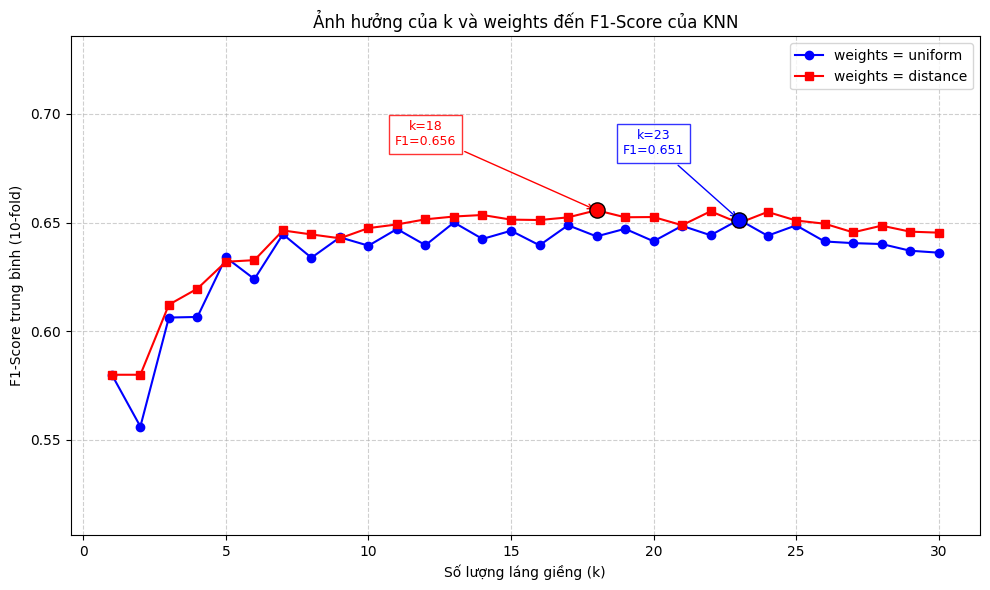


Tìm tham số tối ưu cho RandomForest...


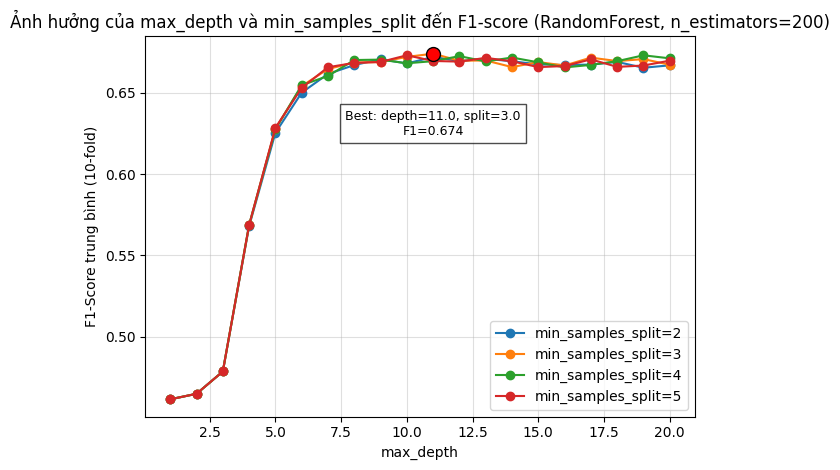


Best Parameters: max_depth=11.0, min_samples_split=3.0, F1=0.6742

🔹 Đang tinh chỉnh tham số cho mô hình KNN ...

🔹 Đang tinh chỉnh tham số cho mô hình RandomForest ...

🔹 Đang tinh chỉnh tham số cho mô hình SVM ...

📊 Kết quả so sánh hiệu năng:
          Model                                        Best Params  F1-Score
0  RandomForest  {'n_estimators': 200, 'max_depth': 10, 'min_sa...  0.673211
1           SVM                          {'C': 1, 'kernel': 'rbf'}  0.667839
2           KNN          {'n_neighbors': 7, 'weights': 'distance'}  0.646366


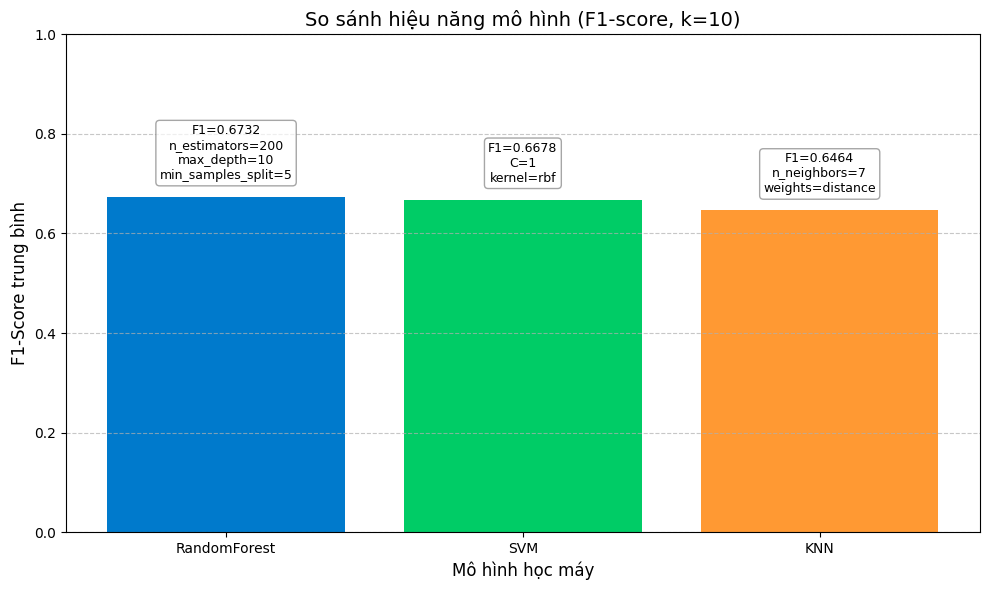

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# --- 1. Đọc dữ liệu ---
df = pd.read_csv("abalone_data.csv")

# --- 2. Mã hóa cột phân loại ---
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])

# --- 3. Chia dữ liệu ---
X = df.drop('Rings', axis=1)
y = df['Rings']

# ⚙️ Chuyển bài toán Regression -> Classification (3 nhóm tuổi)
y = pd.cut(y, bins=[0, 8, 11, 30], labels=[0, 1, 2])
y = y.astype(int)

# --- 4. Chuẩn hóa ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 5. 10-fold Cross Validation ---
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# =========================================================
# Vẽ biểu đồ ảnh hưởng của k đến F1-score (KNN)
# =========================================================
print("\nTìm tham số tối ưu cho KNN...")
neighbors = list(range(1, 31))
f1_uniform = []
f1_distance = []

# Tính F1-score trung bình cho mỗi k và mỗi loại weight
for k in neighbors:
    knn_u = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn_d = KNeighborsClassifier(n_neighbors=k, weights='distance')
    f1_u = cross_val_score(knn_u, X_scaled, y, cv=kf, scoring=make_scorer(f1_score, average='macro')).mean()
    f1_d = cross_val_score(knn_d, X_scaled, y, cv=kf, scoring=make_scorer(f1_score, average='macro')).mean()

    f1_uniform.append(f1_u)
    f1_distance.append(f1_d)

# Chuyển sang numpy array để xử lý dễ hơn
f1_uniform = np.array(f1_uniform)
f1_distance = np.array(f1_distance)

# Tìm best k và giá trị F1 tương ứng
best_idx_uniform = int(np.argmax(f1_uniform))
best_k_uniform = neighbors[best_idx_uniform]
best_f1_uniform = float(f1_uniform[best_idx_uniform])

best_idx_distance = int(np.argmax(f1_distance))
best_k_distance = neighbors[best_idx_distance]
best_f1_distance = float(f1_distance[best_idx_distance])

# --- VẼ BIỂU ĐỒ ---
plt.figure(figsize=(10,6))
plt.plot(neighbors, f1_uniform, marker='o', label='weights = uniform', color='blue')
plt.plot(neighbors, f1_distance, marker='s', label='weights = distance', color='red')

# Đánh dấu điểm tốt nhất (dùng edgecolors để tránh warning)
plt.scatter([best_k_uniform], [best_f1_uniform], color='blue', edgecolors='black', s=120, zorder=5)
plt.scatter([best_k_distance], [best_f1_distance], color='red', edgecolors='black', s=120, zorder=5)

# Annotate (mũi tên) cho uniform (nằm bên trái và trên điểm)
plt.annotate(
    f"k={best_k_uniform}\nF1={best_f1_uniform:.3f}",
    xy=(best_k_uniform, best_f1_uniform),
    xytext=(best_k_uniform-3, best_f1_uniform+0.03),
    arrowprops=dict(arrowstyle="->", color='blue'),
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='blue'),
    color='blue',
    fontsize=9,
    ha='center'
)

# Annotate (mũi tên) cho distance (nằm bên phải và trên/bên dưới tùy chỗ trống)
# Nếu ấn tượng chồng, bạn có thể điều chỉnh xytext thủ công
plt.annotate(
    f"k={best_k_distance}\nF1={best_f1_distance:.3f}",
    xy=(best_k_distance, best_f1_distance),
    xytext=(best_k_distance-6, best_f1_distance+0.03),
    arrowprops=dict(arrowstyle="->", color='red'),
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='red'),
    color='red',
    fontsize=9,
    ha='center'
)

plt.xlabel('Số lượng láng giềng (k)')
plt.ylabel('F1-Score trung bình (10-fold)')
plt.title('Ảnh hưởng của k và weights đến F1-Score của KNN')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

ymin = min(f1_uniform.min(), f1_distance.min()) - 0.05
ymax = max(f1_uniform.max(), f1_distance.max()) + 0.08
plt.ylim(max(0, ymin), min(1.0, ymax))

plt.tight_layout()
plt.show()

print(f"Best k (uniform) = {best_k_uniform}, F1 = {best_f1_uniform:.4f}")
print(f"Best k (distance) = {best_k_distance}, F1 = {best_f1_distance:.4f}")



#==========================================================
#Vẽ biểu đồ tham số mô hình Random Forest
# =========================================================
print("\nTìm tham số tối ưu cho RandomForest...")

max_depths = range(1, 21)
splits = [2, 3, 4, 5]

results = []

for split in splits:
    f1_scores = []
    for depth in max_depths:
        rf = RandomForestClassifier(
            n_estimators=200,
            max_depth=depth,
            min_samples_split=split,
            random_state=42
        )
        f1 = cross_val_score(
            rf, X_scaled, y,
            cv=kf,
            scoring=make_scorer(f1_score, average='macro'),
            n_jobs=-1
        ).mean()
        f1_scores.append(f1)
        results.append({"max_depth": depth, "min_samples_split": split, "f1_score": f1})
    plt.plot(max_depths, f1_scores, marker='o', label=f"min_samples_split={split}")

# Tìm điểm tốt nhất trong toàn bộ kết quả
results_df = pd.DataFrame(results)
best_row = results_df.loc[results_df['f1_score'].idxmax()]

# Vẽ dấu chấm cho điểm tốt nhất
plt.scatter(best_row['max_depth'], best_row['f1_score'], color='red', s=100, edgecolor='black', zorder=5)
plt.text(
    best_row['max_depth'], best_row['f1_score'] - 0.05,
    f"Best: depth={best_row['max_depth']}, split={best_row['min_samples_split']}\nF1={best_row['f1_score']:.3f}",
    ha='center', fontsize=9, bbox=dict(facecolor='white', alpha=0.7)
)

# Cấu hình biểu đồ
plt.figure(1)
plt.title("Ảnh hưởng của max_depth và min_samples_split đến F1-score (RandomForest, n_estimators=200)")
plt.xlabel("max_depth")
plt.ylabel("F1-Score trung bình (10-fold)")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

print(f"\nBest Parameters: max_depth={best_row['max_depth']}, min_samples_split={best_row['min_samples_split']}, F1={best_row['f1_score']:.4f}")



# =========================================================
# Huấn luyện + tinh chỉnh các mô hình
# =========================================================
best_params = {
    "KNN": {"n_neighbors": 7, "weights": "distance"},
    "RandomForest": {"n_estimators": 200, "max_depth": 11, "min_samples_split": 3},
    "SVM": {"C": 1, "kernel": "rbf"}
}

# Danh sách mô hình
models = {
    "KNN": KNeighborsClassifier(**best_params["KNN"]),
    "RandomForest": RandomForestClassifier(random_state=42, **best_params["RandomForest"]),
    "SVM": SVC(random_state=42, **best_params["SVM"])
}

# --- Đánh giá hiệu năng bằng cross-validation ---
results = []
for name, model in models.items():
    print(f"\nĐang tinh chỉnh tham số cho mô hình {name} ...")
    f1 = cross_val_score(model, X_scaled, y, cv=kf, scoring=make_scorer(f1_score, average="macro")).mean()
    results.append({
        "Model": name,
        "Best Params": best_params[name],
        "F1-Score": f1
    })


# =========================================================
# Hiển thị bảng kết quả
# =========================================================
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)
print("\nKết quả so sánh hiệu năng:")
print(results_df)

# =========================================================
# Vẽ biểu đồ so sánh hiệu năng các mô hình
# =========================================================
plt.figure(figsize=(10,6))
bars = plt.bar(results_df["Model"], results_df["F1-Score"], color=['#007acc','#00cc66','#ff9933'])
plt.title("So sánh hiệu năng mô hình (F1-score, k=10)", fontsize=14)
plt.xlabel("Mô hình học máy", fontsize=12)
plt.ylabel("F1-Score trung bình", fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Hiển thị F1-score và tham số trên từng cột
for bar, (_, row) in zip(bars, results_df.iterrows()):
    yval = bar.get_height()
    params_text = "\n".join([f"{k}={v}" for k, v in row["Best Params"].items()])
    plt.text(
        bar.get_x() + bar.get_width()/2,
        yval + 0.03,
        f"F1={yval:.4f}\n{params_text}",
        ha='center', va='bottom', fontsize=9,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round,pad=0.3')
    )

plt.tight_layout()
plt.show()
